# Final Project - Sport Clssification 

Introduction 

Over this course we have learned plenty of different methods for deep learning and artificial intelligence tasks, including building neural networks with all different kinds of compositions. We wanted, of course, to expand on this and decided to apply this on a problem that lies close to our hearts, namely sports. Therefore, we will train and tune neural network in order to obtain the best possible accuracy for this task, and try to apply this base model on different ways of manipulating/transforming image data, which we both found particularly interesting. 

The dataset augmentation will be devided into three parts, one part will cover one method. We will be using, image Translation, Rotation and Scaling an see which preformce best. The base model will be a benchmark for for the models trained on the manipulated images to see which method is best in our case.

We will not just manipulate the data set rather manipluate a proportion of the data and add it to the original data set to so if the model preformce better on a larger data set.  

## 0. Load libraries & Data

In [3]:
# Load reguierd libraries

import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

In [6]:
# Creat the path to the data 
# The data is saved local 

train_dir = '//Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/data/train'
test_dir= '//Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/data/test'
val_dir = '//Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/data/valid'

## 1. The data set

This dataset consists of images of players who practices different sports. There are 100 different classes where 13493 are for training, 500 for test and 500 for validation. The images are in the 224,224,3 jpg format. The dataset were gathered from internet searches and scanned with a duplicate image detector program the owner of the dataset wrote. 

In [68]:
def show_random_images_with_labels(main_folder, num_images=5):

  subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) 
                if os.path.isdir(os.path.join(main_folder, f))]
  random.shuffle(subfolders)  # Randomize the order of subfolders

  fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
  for i, subfolder in enumerate(subfolders[:num_images]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)  # Randomize the order of images within the subfolder
    image_path = image_paths[0]  # Select the first random image

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path) + f" ({os.path.basename(subfolder)})", fontsize=10)  # Add label in title

  plt.tight_layout()
  plt.show()

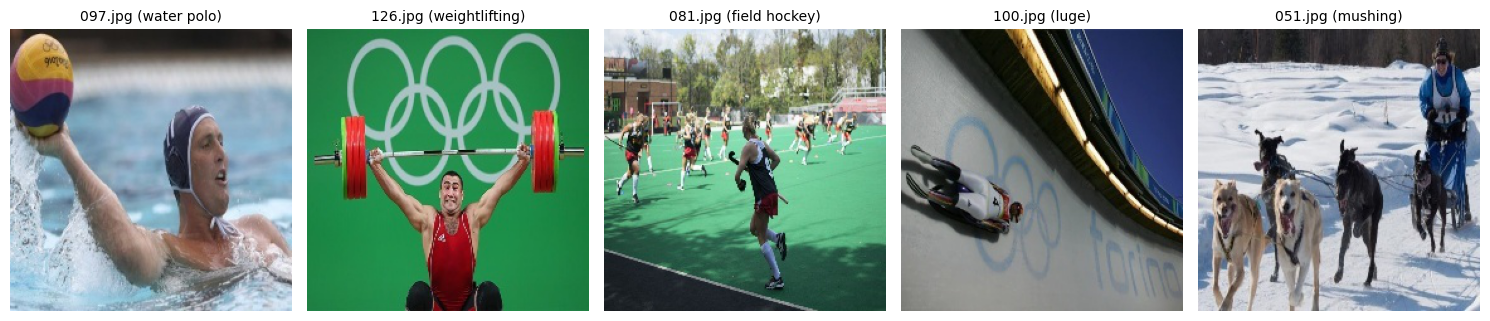

In [69]:
show_random_images_with_labels(train_dir,5)

# 2. Create an ImageDataGenerator for Training, Validating and Testing data

In [16]:
train_datagen = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)


train_dg = train_datagen.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)

Found 17498 images belonging to 100 classes.


In [17]:
val_datagen = ImageDataGenerator()
validation_dg = val_datagen.flow_from_directory(val_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 128,
                                      shuffle = False,
                                      seed = 42)

Found 500 images belonging to 100 classes.


In [18]:
testing_dg = val_datagen.flow_from_directory(test_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 128,
                                      shuffle = False,
                                      seed = 42)

Found 500 images belonging to 100 classes.


## 3. Define the base model

In [22]:
# We will use the pre-trained model "EfficientNetB0"

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model


# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))

# Freeze the base model layers 
for layer in base_model.layers:
  layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(100, activation="softmax")(x)  # Adjust output size for 500 species

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

This model, which is an EfficientNetB0 model that was pre-trained on the famous ImageNet dataset, is our foundation for our image classification model of different sports. This technique is known as transfer learning, where a model developed for one task is repurposed on a second, related task. First, we import the EfficientNetB0 model from TensorFlow’s keras application and then customize it for our new classification task by freezing its layers to prevent them from being updated during training, to ensure that the pre-learned features are intact. 

Following this, we add custom layers on top of the base EfficientNetB0 model to tailor it for our specific classification problem. The custom layers include a Global Average Pooling 2D layer to reduce the dimensionality of the feature maps, a Dropout layer to reduce overfitting by randomly setting input units to 0 at each update, and a Dense layer to perform the classification. The Dense layer’s output size is set to 100 (because we have 100 classes). The model also uses the softmax activation function in the final layer to output a probability distribution over the 100 categories.

In [24]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [19]:
history_base = model.fit(
      train_dg,
      epochs=30,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/30
106/106 [==============================] - 233s 2s/step - loss: 1.1610 - accuracy: 0.7257 - val_loss: 0.2779 - val_accuracy: 0.9260 - lr: 0.0050
Epoch 2/30
106/106 [==============================] - 230s 2s/step - loss: 0.3936 - accuracy: 0.8956 - val_loss: 0.2041 - val_accuracy: 0.9360 - lr: 0.0050
Epoch 3/30
106/106 [==============================] - 230s 2s/step - loss: 0.2850 - accuracy: 0.9214 - val_loss: 0.1777 - val_accuracy: 0.9460 - lr: 0.0050
Epoch 4/30
106/106 [==============================] - 229s 2s/step - loss: 0.2315 - accuracy: 0.9340 - val_loss: 0.1624 - val_accuracy: 0.9540 - lr: 0.0050
Epoch 5/30
106/106 [==============================] - 230s 2s/step - loss: 0.1953 - accuracy: 0.9423 - val_loss: 0.1313 - val_accuracy: 0.9560 - lr: 0.0050
Epoch 6/30
106/106 [==============================] - 229s 2s/step - loss: 0.1761 - accuracy: 0.9509 - val_loss: 0.1459 - val_accuracy: 0.9500 - lr: 0.0050
Epoch 7/30
106/106 [==============================] - 230s 2s/st

In [5]:
import json

#Function to convert NumPy types to Python native types for JSON serialization
def convert_to_json_serializable(history):
    history_dict = {}
    for key, value in history.items():
        if isinstance(value, list):  # For lists
            history_dict[key] = [float(x) if isinstance(x, np.float32) else x for x in value]
        else:
            history_dict[key] = value
    return history_dict

#Convert the history to be JSON serializable
history_serializable = convert_to_json_serializable(history_base.history)





In [6]:
import json
# Save the training history as JSON
history_path = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_base.json'
with open(history_path, 'w') as f:
    json.dump(history_serializable, f)

NameError: name 'history_serializable' is not defined

## 4. Evaluate the Model

In [8]:
import json

# Load the training history from JSON
history_path = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_base.json'
with open(history_path, 'r') as f:
    history_base = json.load(f)

# Now, history_loaded contains your training history.
# Extracting training and validation metrics from the loaded history object
train_acc = history_base['accuracy']
val_acc = history_base['val_accuracy']
train_loss = history_base['loss']
val_loss = history_base['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

On the left plot we can see the training and validation accuracy. We can see that the validation accuracy starts high and continues to improve over the epochs, which is a good indication that the model is learning from the training data. The validation accuracy also increases and then plateaus, which indicates that the model is generalizing well to new unseen data. We also notice that there is a small gap between the training and validation accuracy which could suggest a small amount of overfitting. However, this gap is not significant so this does not seem to be the case here. 

The right plot shows the loss on the training and validation datasets. The training loss decreases rapidly at first and then levels off, which is typical and indicates that the model is learning from the training data. The validation loss decreases alongside the training loss and then levels off, closely following the training loss curve. This is a good sign because it means that the model isn’t just memorizing the training data but is learning general patterns that apply to the validation data as well. The training and validation loss curves are also close together without a large gap, which could be an indication of overfitting. 

Overall, the models appears to be performing well. The accuracy is high and stable and the loss is low for both the training and validation sets. The model does not appear to be overfitting significantly, as indicated by the close performance metrics of training and validation sets. 

In [37]:
predictions=model.evaluate(testing_dg)
# test loss: 0.0614 - test accuracy: 0.9800

4/4 [==============================] - 9s 2s/step - loss: 0.0614 - accuracy: 0.9800


The base model has a testing accuracy of 98% will be the benchmark for the future model that will be trained on added manipulated images. 

In [43]:
# Get true labels
true_labels = testing_dg.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(testing_dg), axis=1)


report = classification_report(true_labels, predicted_labels, target_names=testing_dg.class_indices.keys(), 
                               output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Correct the support column data type (it comes as float because of the averages rows)
report_df['support'] = report_df['support'].astype(int)

4/4 [==============================] - 8s 2s/step


In [47]:
sorted_report_df = report_df.sort_values(by='precision', ascending=True)
classes_only_df = sorted_report_df.drop(index= ['accuracy', 'weighted avg', 'macro avg'])


def highlight_low_values(s, props=''):
    return np.where(s < 1.00, props, '')

# Apply the styling for both 'precision' and 'f1-score' columns
styled_df = classes_only_df.style.apply(lambda x: highlight_low_values(x, 'color:red;'), 
                                        subset=['precision', 'f1-score'], axis=1)
styled_df

From this table, we can see the precision, recall, f1-score and support for our different classes on our test data. We can see that for the majority of the classes, we have obtained 100 % accuracy, meaning 1 in precision, recall and f1-score. There are a few classes that doesn’t have 100 % accuracy but only a few misclases, which indicates that we have a very solid model at performing this task.

## 5. Transform the Data

https://medium.com/mlait/affine-transformation-image-processing-in-tensorflow-part-1-df96256928a

We will transform 30% of the data set and add the manipulated images to the data set. There fore the model will be trained on 30% more data points 

## 6. Translation 

A translation is a function that moves every point with a constant distance in a specified direction. In TensorFlow, it is specified as tx and ty which will provide the orientation and the distance.

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing.image import apply_affine_transform
import tensorflow as tf


# Function to pad and translate an image tensor
def translate_image(image_tensor, pad_left, pad_right, pad_top, pad_bottom, target_height, target_width):
    padded_image = tf.image.pad_to_bounding_box(
        image_tensor, pad_top, pad_left, target_height + pad_bottom + pad_top, target_width + pad_right + pad_left
    )
    output_image = tf.image.crop_to_bounding_box(
        padded_image, pad_bottom, pad_right, target_height, target_width
    )
    return output_image

# Apply the translation to a subset of images in the dataset
def translate_and_expand_dataset(train_folder, translation_percentage=0.3, tx=30, ty=30):
    # Get all image paths
    image_paths = []
    for subdir, dirs, files in os.walk(train_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(subdir, file))

    # Calculate how many images to transform
    num_images_to_transform = int(len(image_paths) * translation_percentage)

    # Select a random subset of images to transform
    images_to_transform = random.sample(image_paths, num_images_to_transform)

    for image_path in images_to_transform:
        img = Image.open(image_path)  # Open the image with PIL
        img = img.convert('RGB')  # Convert the image to RGB
        img_array = np.array(img)  # Convert the image to a numpy array

        # Convert the image to a tensor, add batch dimension, and process with translation
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        img_tensor = tf.expand_dims(img_tensor, 0)  # Add the batch dimension

        # Apply the affine transformation - for translation
        height, width, channels = img_array.shape
        translated_tensor = translate_image(
            img_tensor, 0, tx, 0, ty, height, width
        )

        # Convert the tensor to an image array
        translated_img_array = translated_tensor.numpy().astype(np.uint8)
        translated_img_array = np.squeeze(translated_img_array, axis=0)  # Remove the batch dimension

        # Convert the translated image array back into an image
        transformed_img = Image.fromarray(translated_img_array, 'RGB')
        # Generate a new file name and save the transformed image
        base_path, ext = os.path.splitext(image_path)
        new_image_path = base_path + '_translated' + ext
        transformed_img.save(new_image_path)

    print(f"Transformed and saved {num_images_to_transform} images.")


train_folder = train_dir 
translate_and_expand_dataset(train_folder, translation_percentage=0.3, tx=30, ty=30)

Transformed and saved 4368 images.


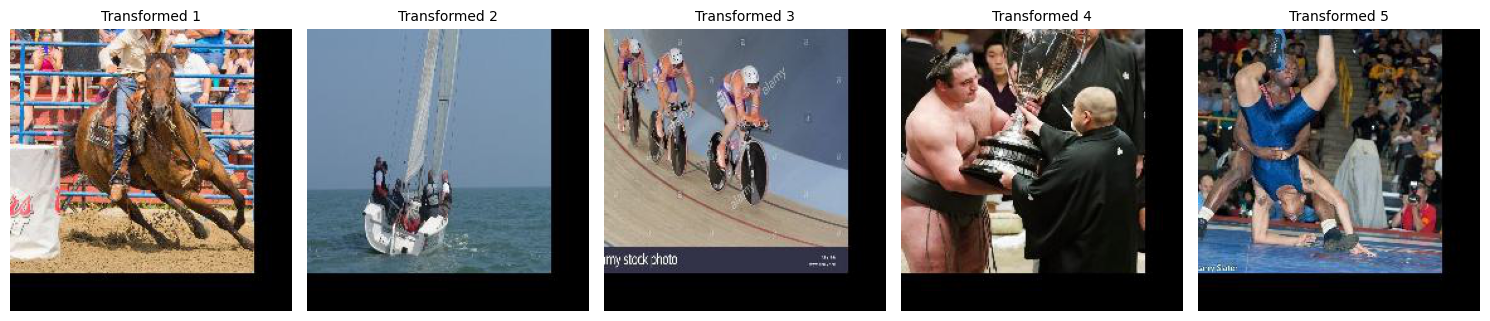

In [75]:
def show_random_transformed_images(train_folder, num_images=5):
    # Get all image paths that have '_translated' in the filename
    transformed_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_folder) 
                               for f in filenames if '_translated' in f]

    # Select a random subset of the transformed images to display
    images_to_display = random.sample(transformed_image_paths, num_images)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5), squeeze=False)
    axes = axes.flatten()

    # Loop over the selected images and plot them
    for i, image_path in enumerate(images_to_display):
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Transformed {i+1}', fontsize=10)

    plt.tight_layout()
    plt.show()

show_random_transformed_images(train_folder, num_images=5)

In [80]:
# Update the train_dg so it include the new transformed images 

train_dg = train_datagen.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)

# Create a new model with the exact same architecture as the base model
# Load the EfficientNetB0 model pre-trained on ImageNet
model_tran = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))

# Freeze the base model layers 
for layer in model_tran.layers:
  layer.trainable = False

# Add custom layers for classification
x = model_tran.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(100, activation="softmax")(x)  # Adjust output size for 500 species

# Create the final model
model_translation = Model(inputs=model_tran.input, outputs=predictions)

model_translation.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Found 18603 images belonging to 100 classes.


In [82]:
history_translation = model_translation.fit(
      train_dg,
      epochs=30,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/30
146/146 [==============================] - 316s 2s/step - loss: 2.2799 - accuracy: 0.5721 - val_loss: 0.9767 - val_accuracy: 0.8460 - lr: 2.0000e-04
Epoch 2/30
146/146 [==============================] - 319s 2s/step - loss: 1.1051 - accuracy: 0.8074 - val_loss: 0.6385 - val_accuracy: 0.8880 - lr: 2.0000e-04
Epoch 3/30
146/146 [==============================] - 316s 2s/step - loss: 0.8621 - accuracy: 0.8421 - val_loss: 0.5069 - val_accuracy: 0.9080 - lr: 2.0000e-04
Epoch 4/30
146/146 [==============================] - 311s 2s/step - loss: 0.7340 - accuracy: 0.8570 - val_loss: 0.4344 - val_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 5/30
146/146 [==============================] - 311s 2s/step - loss: 0.6558 - accuracy: 0.8731 - val_loss: 0.3790 - val_accuracy: 0.9380 - lr: 2.0000e-04
Epoch 6/30
146/146 [==============================] - 311s 2s/step - loss: 0.5930 - accuracy: 0.8825 - val_loss: 0.3461 - val_accuracy: 0.9380 - lr: 2.0000e-04
Epoch 7/30
146/146 [====================

In [85]:
# Save the training history as JSON
history_serializable_translation = convert_to_json_serializable(history_translation.history)


history_path_translation = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_translation.json'
with open(history_path_translation, 'w') as f:
    json.dump(history_serializable_translation, f)

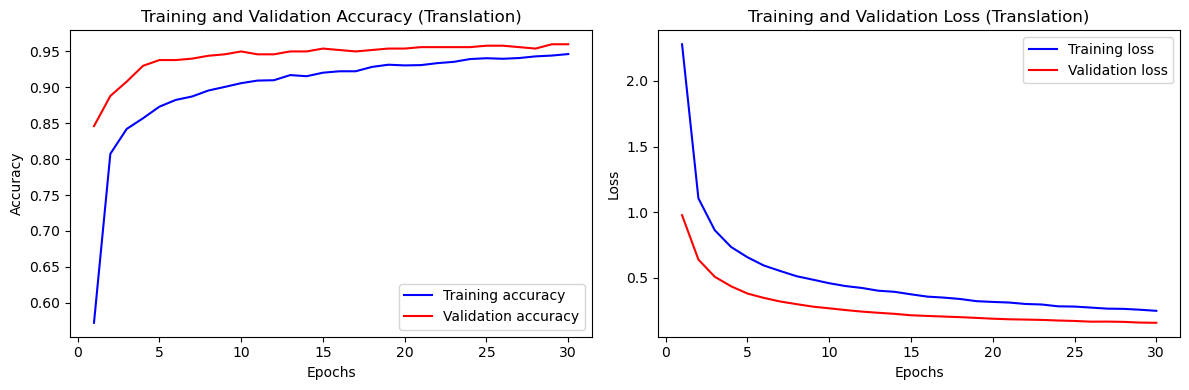

In [6]:
# Load the training history from JSON
history_path_translation = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_translation.json'
with open(history_path_translation, 'r') as f:
    history_translation = json.load(f)

# Now, history_loaded contains your training history.
# Extracting training and validation metrics from the loaded history object
train_acc_translation = history_translation['accuracy']
val_acc_translation = history_translation['val_accuracy']
train_loss_translation = history_translation['loss']
val_loss_translation = history_translation['val_loss']

epochs = range(1, len(train_acc_translation) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_translation, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_translation, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Translation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_translation, 'b', label='Training loss')
plt.plot(epochs, val_loss_translation, 'r', label='Validation loss')
plt.title('Training and Validation Loss (Translation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [87]:
predictions_translation=model_translation.evaluate(testing_dg)


4/4 [==============================] - 8s 2s/step - loss: 0.1168 - accuracy: 0.9760


In the left plot that displays the training and validation accuracy of the translation-augmented model, we notice a slightly different behavior compared to the base model. While the base model’s validation accuracy started high and plateaued early, the translation model’s validation accuracy shows a more gradual improvement over epochs. This may suggest that the translation model is benefiting from the diversity of the translated data. Despite a visible gap between the training and validation accuracy, overfitting in this case is not a significant issue, and the model retains a good valance between learning from training data and generalizing to validation data.

For the loss curves which can be found in the right plot, the translation-augmented model displays a learning pattern where both training and validation loss decrease steadily. Compared to the base model, the translation model’s validation loss starts higher but converges closer to the training loss over time. This behavior may be attributed to the model’s adaptation to the variability introduced by the translation, which after an initial period of adjustments leads to a robust trajectory of the model’s learning. While the gap between the training and validation loss is slightly bigger in the translation model than in the base model, it does not indicate a worrying level of overfitting. Rather, it suggests that the model continues to learn and adapt through the training process, without the early plateau observed in the base model’s loss curve.

However, the translation-augmented model appears to have utilized the additional complexity from the translated data to potentially enhance its learning and generalization capability compared to the base model. This is evidenced by the steadier gain in accuracy and a more synchronized reduction in loss across training and validation sets. Its performance on the test data (0.9760) is however 0.4 percentage points lower than the one without any augmented images (0.9800). Since we are running the model with the exact same hyperparameters on the different training datasets (augmented and not augmented) this is very interesting because our model ran on the non-augmented training data only ran for 17 epochs before early stopping kicked in. This however runs for all of the 30 epochs specified without plateauing, and our belief is that if we were to let it run for longer it could possibly gain a small increase in accuracy. However, because of the time factor and the fact that this process is very computer-intensive we chose not to. 

## 7. Rotation

Rotation is a circular transformation around a point or an axis. The angle of rotation can be specified to rotate our image around a point or an axis. We have created a function that takes 30% of the training data and rotates the image 90o.  

Rotation of images can help the model become invariant to the orientation of objects, allowing it to recognize objects regardless of how they're oriented in the field of view.

In some cases, rotation could alter the meaning or semantics of an image. For example, an upside-down image of a person might not only be an unusual orientation but could also imply a different context or action.

In [12]:
def rotate_and_save_images(main_folder, rotation_angle=90, selection_percentage=0.3):
    subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if 
                  os.path.isdir(os.path.join(main_folder, f))]
    total_images = 0  # Initialize a counter for total images
    rotated_images = []

    for subfolder in subfolders:
        image_files = [f for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images += len(image_files)  # Count the images
        selected_files = random.sample(image_files, int(len(image_files) * selection_percentage))

        for file in selected_files:
            image_path = os.path.join(subfolder, file)
            img = Image.open(image_path)
            img_rotated = img.rotate(rotation_angle)
            new_file_name = f"rotated_{file}"
            new_file_path = os.path.join(subfolder, new_file_name)
            img_rotated.save(new_file_path)
            rotated_images.append(new_file_path)
    
    print(f"Total number of images in {main_folder}: {total_images}")  # Print the total number of images
    return rotated_images

def plot_sample_images(image_paths, num_images=5):
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
    for i, image_path in enumerate(image_paths[:num_images]):
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(image_path), fontsize=10)
    plt.tight_layout()
    plt.show()


# Rotate and save images
rotated_images = rotate_and_save_images(train_dir, 90, 0.3)


Total number of images in //Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/data/train: 21893


In [99]:
# Plot a sample of the rotated images
plot_sample_images(rotated_images, 5)

In [90]:
# Update the train_dg so it include the new transformed images and removes the images from Translation

train_dg = train_datagen.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)

# Create a new model with the exact same architecture as the base model
# Load the EfficientNetB0 model pre-trained on ImageNet
model_rot = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))

# Freeze the base model layers 
for layer in model_rot.layers:
  layer.trainable = False

# Add custom layers for classification
x = model_rot.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(100, activation="softmax")(x)  # Adjust output size for 500 species

# Create the final model
model_rotation = Model(inputs=model_rot.input, outputs=predictions)

model_rotation.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Found 17498 images belonging to 100 classes.


In [91]:
history_rotation = model_rotation.fit(
      train_dg,
      epochs=30,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/30
137/137 [==============================] - 298s 2s/step - loss: 2.5103 - accuracy: 0.5125 - val_loss: 1.0791 - val_accuracy: 0.8380 - lr: 2.0000e-04
Epoch 2/30
137/137 [==============================] - 292s 2s/step - loss: 1.3194 - accuracy: 0.7540 - val_loss: 0.7097 - val_accuracy: 0.8800 - lr: 2.0000e-04
Epoch 3/30
137/137 [==============================] - 292s 2s/step - loss: 1.0641 - accuracy: 0.7903 - val_loss: 0.5645 - val_accuracy: 0.8920 - lr: 2.0000e-04
Epoch 4/30
137/137 [==============================] - 295s 2s/step - loss: 0.9275 - accuracy: 0.8139 - val_loss: 0.4881 - val_accuracy: 0.9020 - lr: 2.0000e-04
Epoch 5/30
137/137 [==============================] - 298s 2s/step - loss: 0.8351 - accuracy: 0.8264 - val_loss: 0.4319 - val_accuracy: 0.9120 - lr: 2.0000e-04
Epoch 6/30
137/137 [==============================] - 296s 2s/step - loss: 0.7710 - accuracy: 0.8379 - val_loss: 0.3927 - val_accuracy: 0.9220 - lr: 2.0000e-04
Epoch 7/30
137/137 [====================

In [94]:
# Save the training history as JSON
history_serializable_rotation = convert_to_json_serializable(history_rotation.history)


history_path_rotation = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_rotation.json'
with open(history_path_rotation, 'w') as f:
    json.dump(history_serializable_rotation, f)

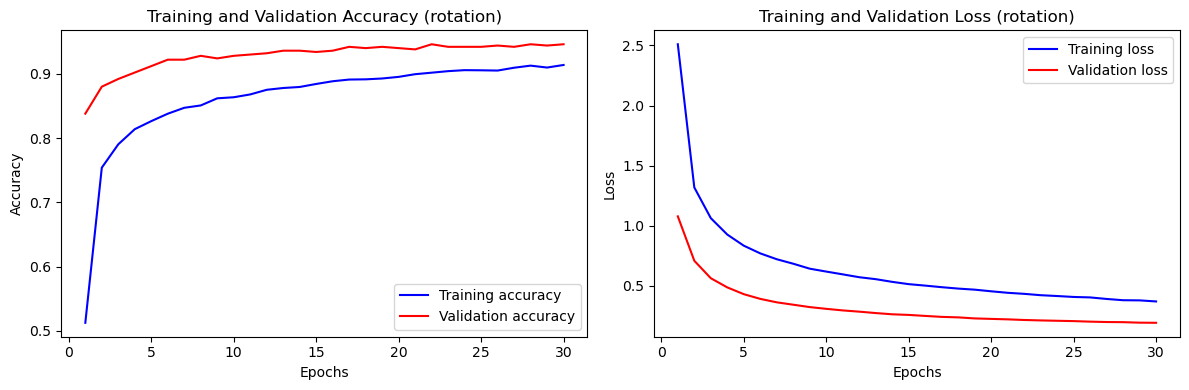

In [9]:
# Load the training history from JSON
history_path_rotation = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_rotation.json'
with open(history_path_rotation, 'r') as f:
    history_rotation = json.load(f)

# Now, history_loaded contains your training history.
# Extracting training and validation metrics from the loaded history object
train_acc_rotation = history_rotation['accuracy']
val_acc_rotation = history_rotation['val_accuracy']
train_loss_rotation = history_rotation['loss']
val_loss_rotation = history_rotation['val_loss']

epochs = range(1, len(train_acc_rotation) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_rotation, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_rotation, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (rotation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_rotation, 'b', label='Training loss')
plt.plot(epochs, val_loss_rotation, 'r', label='Validation loss')
plt.title('Training and Validation Loss (rotation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
predictions_rotation=model_rotation.evaluate(testing_dg)


4/4 [==============================] - 8s 2s/step - loss: 0.1543 - accuracy: 0.9720


While examining the training and validation accuracy plots of the rotation-augmented model, we identify clear differences from the base model's performance. The base model achieved high validation accuracy early on and plateaued, suggesting rapid learning but early stagnation in terms of model improvement from additional training. In contrast, the rotation model shows a slower initial increase in validation accuracy, then it continues to rise throughout the training epochs. This indicates a continuous learning curve and suggests that the inclusion of rotated images introduces beneficial complexity, enhancing the model's ability to generalize. The small gap between the training and validation accuracy suggests that while there might be a slight overfitting in the rotation model, it is still within a reasonable range and does not impose a problem to the model's generalization ability.


Looking at the loss plots, we see that the base model's training and validation loss converge relatively quickly, suggesting that the model is efficiently learning from the training data and generalizing well to unseen data. The rotation model, on the other hand, exhibits a higher initial validation loss compared to the training loss. However, as training progresses, the validation loss decreases and starts to align more closely with the training loss. This could imply that the rotation-augmented model, like the translation model, is learning more nuanced features, though it might require more epochs to fully optimize compared to the base model.


It is important to note that the rotation model's accuracy on test data is 97.20%, which is slightly lower than the base model's 98.00%. Despite the extended training to 30 epochs, unlike the base model which stopped early at 17 epochs, the rotation model did not surpass the base model's accuracy. This suggests that while rotational data augmentation does contribute to a more generalized and robust model, it does not necessarily lead to higher accuracy on this particular test set. Similar to the translation model, the rotation model might benefit from additional epochs of training; however, given computational constraints and the potential for only marginal gains, extending training may not be justified.

## 8. Scaling

Scaling is a linear transformation that enlarges or shrinks objects by a scale factor that is the same in all directions. The values of the sx and sy can be specified to enlarge or shrink our images. It is basically zooming in the image or zooming out the image.

In [13]:
from PIL import ImageOps

def scale_and_save_images(main_folder, scale_factor=1.2, selection_percentage=0.3):
    subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if 
                  os.path.isdir(os.path.join(main_folder, f))]
    scaled_images = []

    for subfolder in subfolders:
        image_files = [f for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        selected_files = random.sample(image_files, int(len(image_files) * selection_percentage))

        for file in selected_files:
            image_path = os.path.join(subfolder, file)
            img = Image.open(image_path)
            original_size = img.size

            # Calculate new size according to the scale factor
            new_size = (int(original_size[0] * scale_factor), int(original_size[1] * scale_factor))
            img_scaled = img.resize(new_size, Image.ANTIALIAS)

            new_file_name = f"scaled_{file}"
            new_file_path = os.path.join(subfolder, new_file_name)
            img_scaled.save(new_file_path)
            scaled_images.append(new_file_path)
    
    return scaled_images

# Scale and save images
scaled_images = scale_and_save_images(train_dir, 3.5, 0.3)

/var/folders/y7/5vs32zwd20xcj5l48nlykb6h0000gn/T/ipykernel_53236/1411634668.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_scaled = img.resize(new_size, Image.ANTIALIAS)


In [14]:
# Plot a sample of the scaled images
plot_sample_images(scaled_images, 5)

In [25]:
# Update the train_dg so it include the new transformed images and removes the images from Translation

train_dg = train_datagen.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)

# Create a new model with the exact same architecture as the base model
# Load the EfficientNetB0 model pre-trained on ImageNet
model_sca = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))

# Freeze the base model layers 
for layer in model_sca.layers:
  layer.trainable = False

# Add custom layers for classification
x = model_sca.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(100, activation="softmax")(x)  # Adjust output size for 500 species

# Create the final model
model_scale = Model(inputs=model_sca.input, outputs=predictions)

model_scale.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Found 17498 images belonging to 100 classes.


In [26]:
history_scale = model_scale.fit(
      train_dg,
      epochs=30,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/30
137/137 [==============================] - 312s 2s/step - loss: 1.0008 - accuracy: 0.7619 - val_loss: 0.2426 - val_accuracy: 0.9340 - lr: 0.0050
Epoch 2/30
137/137 [==============================] - 320s 2s/step - loss: 0.3284 - accuracy: 0.9119 - val_loss: 0.1733 - val_accuracy: 0.9540 - lr: 0.0050
Epoch 3/30
137/137 [==============================] - 312s 2s/step - loss: 0.2421 - accuracy: 0.9312 - val_loss: 0.1687 - val_accuracy: 0.9520 - lr: 0.0050
Epoch 4/30
137/137 [==============================] - 317s 2s/step - loss: 0.1946 - accuracy: 0.9457 - val_loss: 0.1383 - val_accuracy: 0.9520 - lr: 0.0050
Epoch 5/30
137/137 [==============================] - 313s 2s/step - loss: 0.1699 - accuracy: 0.9510 - val_loss: 0.1278 - val_accuracy: 0.9600 - lr: 0.0050
Epoch 6/30
137/137 [==============================] - 296s 2s/step - loss: 0.1478 - accuracy: 0.9571 - val_loss: 0.1271 - val_accuracy: 0.9660 - lr: 0.0050
Epoch 7/30
137/137 [==============================] - 300s 2s/st

In [31]:
# Save the training history as JSON
history_serializable_scale = convert_to_json_serializable(history_scale.history)


history_path_scale = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_scale.json'
with open(history_path_scale, 'w') as f:
    json.dump(history_serializable_scale, f)

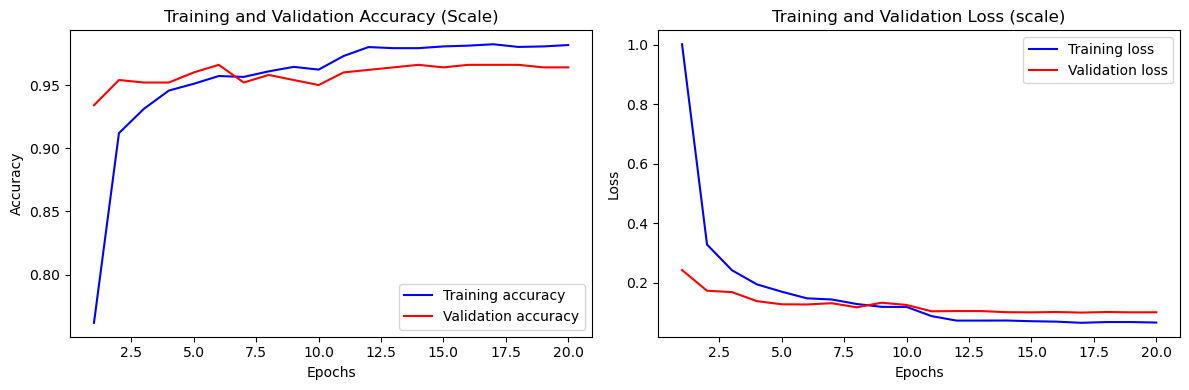

In [16]:
# Load the training history from JSON
history_path_scale = '/Users/viktorsjoberg/Desktop/Deep Learning & AI/Final project/fit/history_scale.json'
with open(history_path_scale, 'r') as f:
    history_scale = json.load(f)

# Now, history_loaded contains your training history.
# Extracting training and validation metrics from the loaded history object
train_acc_scale = history_scale['accuracy']
val_acc_scale = history_scale['val_accuracy']
train_loss_scale = history_scale['loss']
val_loss_scale = history_scale['val_loss']

epochs = range(1, len(train_acc_scale) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_scale, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_scale, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Scale)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_scale, 'b', label='Training loss')
plt.plot(epochs, val_loss_scale, 'r', label='Validation loss')
plt.title('Training and Validation Loss (scale)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
predictions_scale=model_scale.evaluate(testing_dg)


4/4 [==============================] - 8s 2s/step - loss: 0.0723 - accuracy: 0.9780


While examining the training and validation accuracy plots of the scale-augmented model, we identify clear similarities from the base model's performance. The base model achieved high validation accuracy early on and plateaued, suggesting rapid learning but early stagnation in terms of model improvement from additional training. For the scale model shows a similiar initial increase in validation accuracy, then it do not to rise throughout the training epochs. This indicates a noncontinuous learning curve and suggests that the inclusion of scaled images does not beneficial complexity. The small gap between the training and validation accuracy suggests that while there might be a slight overfitting in the scale model, it is still within a reasonable range and does not impose a problem to the model's generalization ability.


Looking at the loss plots, we see that the base model's training and validation loss converge relatively quickly, suggesting that the model is efficiently learning from the training data and generalizing well to unseen data. The scale model, on the other hand, exhibits a higher initial validation loss compared to the training loss. However, as training progresses, the validation loss decreases and starts to align more closely with the training loss. Furthermore, the scale model is the only agumentation model that stoped before all epochs were done running. Indicating that it has come to it´s peak eariler then translation and roation model. 


It is important to note that the scale model's accuracy on test data is 97.80%, which is slightly lower than the base model's 98.00%, but the highest compared to the augmented models, and was trained on the least ammount of epochs. This suggests that while scale data augmentation does contribute to a more generalized and robust model, it does not necessarily lead to higher accuracy on this particular test set. 

## 9. Conclusion 

In evaluating the performance of our base model, it's noteworthy that the measures of scale, rotation, and translation all approached the accuracy of the base model, despite the latter undergoing the fewest training epochs. This observation underscores the robustness of our base model, which benefits from a substantial dataset. It highlights an important principle in machine learning: dataset augmentation tends to yield the most significant benefits in scenarios where the original dataset is relatively small. Our experiment further supports this notion, as even with the introduction of an additional 30% manipulated data points, the model's performance did not deteriorate. This suggests that the model was capable of extracting valuable information from the augmented images, thereby enhancing its learning potential.

Both the rotation and translation models continued to learn without early stopping, indicating that with higher number of epochs training, they might surpass the baseline model in terms of accuracy. This possibility opens up avenues for future research, where extending the training period could potentially unlock higher levels of model performance. It is crucial to recognize that the effectiveness of data augmentation techniques, such as manipulation through rotation and translation, is not merely a strategy for compensating for a lack of data. Instead, these techniques can introduce a form of diversity in the training process that is inherently beneficial, providing the model with a broader spectrum of features to learn from.

Moreover, this experiment sheds light on the resilience of machine learning models to variations in training data. The fact that the augmented data did not negatively impact the model's performance is indicative of the model's ability to generalize from a diverse dataset. It suggests that there is a threshold of data manipulation beyond which the model can still learn effectively, without overfitting or underfitting to the augmented data. This insight is valuable for the development of more adaptive and robust machine learning systems.

In conclusion, our findings reinforce the importance of having a strong base model and the good use of dataset augmentation. The success of the rotation and translation models in continuing to learn without early stopping underscores the potential for further accuracy improvements with extended training. Moving forward, it will be essential to explore the balance between the quantity of training data, the extent of data manipulation, and the duration of training epochs to optimize machine learning models for diverse applications. 

In [12]:
def plot_combined_metrics(history_base, history_scale, history_rotation, history_translation):
    # Plotting
    plt.figure(figsize=(20, 8))
    
    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_base['accuracy']) + 1), history_base['accuracy'], label='Training Acc (Base)')
    plt.plot(range(1, len(history_base['val_accuracy']) + 1), history_base['val_accuracy'], label='Validation Acc (Base)')
    plt.plot(range(1, len(history_scale['accuracy']) + 1), history_scale['accuracy'], label='Training Acc (Scale)')
    plt.plot(range(1, len(history_scale['val_accuracy']) + 1), history_scale['val_accuracy'], label='Validation Acc (Scale)')
    plt.plot(range(1, len(history_rotation['accuracy']) + 1), history_rotation['accuracy'], label='Training Acc (Rotation)')
    plt.plot(range(1, len(history_rotation['val_accuracy']) + 1), history_rotation['val_accuracy'], label='Validation Acc (Rotation)')
    plt.plot(range(1, len(history_translation['accuracy']) + 1), history_translation['accuracy'], label='Training Acc (Translation)')
    plt.plot(range(1, len(history_translation['val_accuracy']) + 1), history_translation['val_accuracy'], label='Validation Acc (Translation)')
    plt.title('Training and Validation Accuracy for Different Augmentations')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history_base['loss']) + 1), history_base['loss'], label='Training Loss (Base)')
    plt.plot(range(1, len(history_base['val_loss']) + 1), history_base['val_loss'], label='Validation Loss (Base)')
    plt.plot(range(1, len(history_scale['loss']) + 1), history_scale['loss'], label='Training Loss (Scale)')
    plt.plot(range(1, len(history_scale['val_loss']) + 1), history_scale['val_loss'], label='Validation Loss (Scale)')
    plt.plot(range(1, len(history_rotation['loss']) + 1), history_rotation['loss'], label='Training Loss (Rotation)')
    plt.plot(range(1, len(history_rotation['val_loss']) + 1), history_rotation['val_loss'], label='Validation Loss (Rotation)')
    plt.plot(range(1, len(history_translation['loss']) + 1), history_translation['loss'], label='Training Loss (Translation)')
    plt.plot(range(1, len(history_translation['val_loss']) + 1), history_translation['val_loss'], label='Validation Loss (Translation)')
    plt.title('Training and Validation Loss for Different Augmentations')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

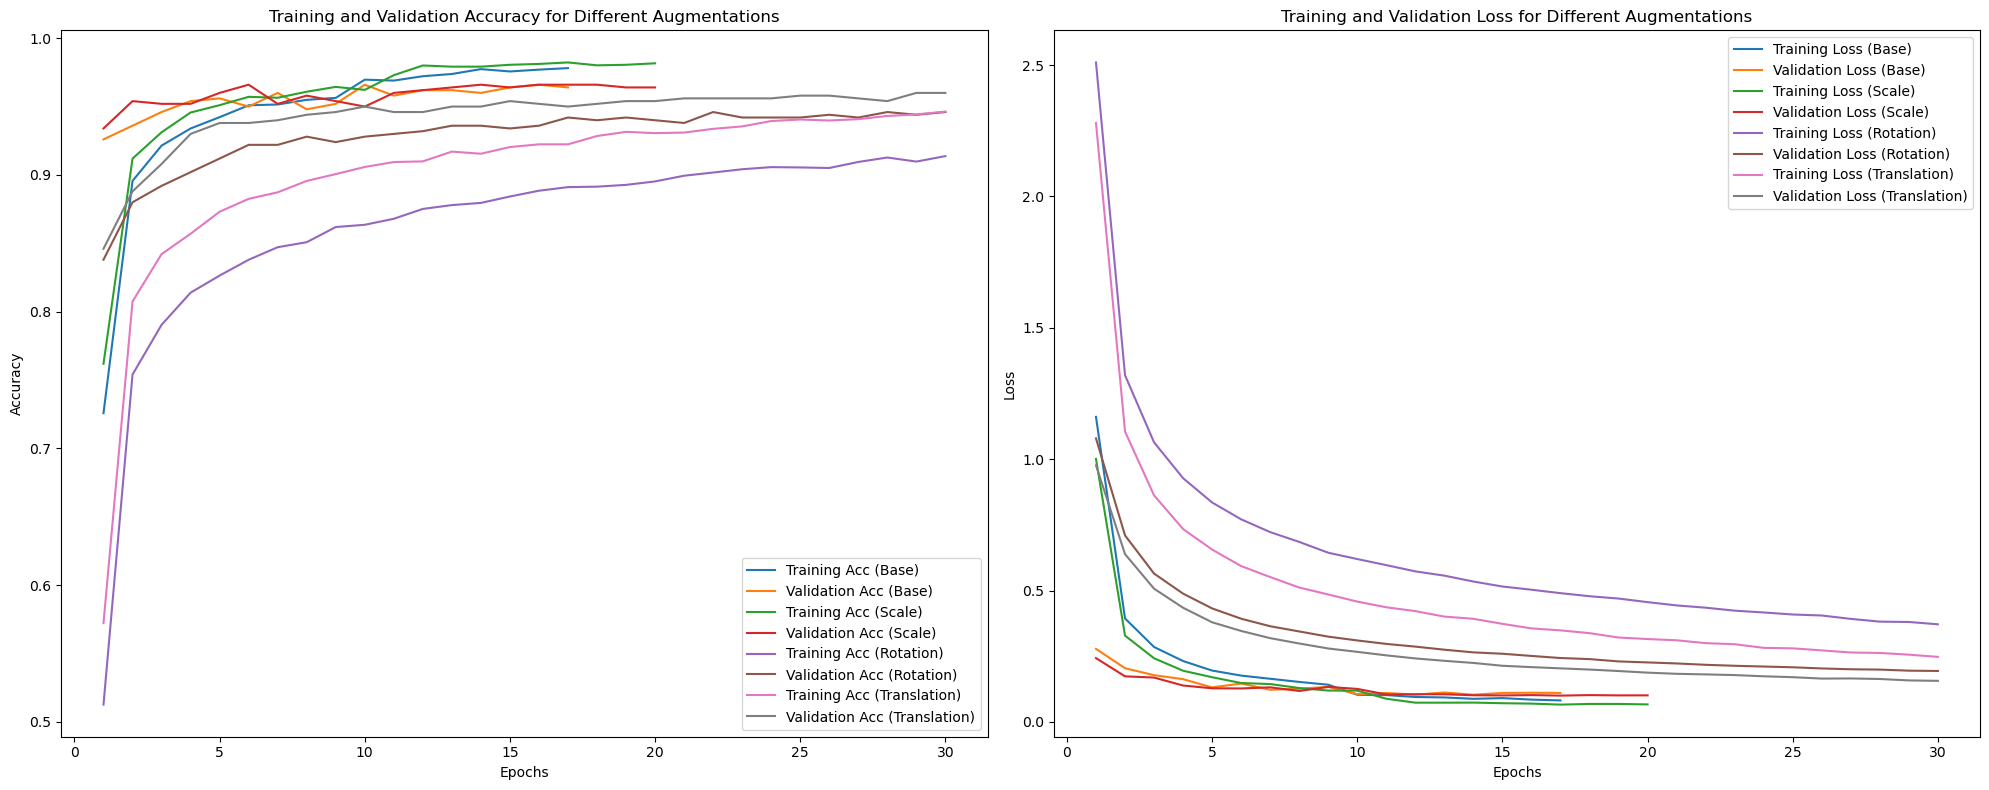

In [14]:
plot_combined_metrics(history_base, history_scale, history_rotation, history_translation)
